In [1]:
# open the generated synthetic data file and read it as a python dictionary called data

import json

file = open('synthetic_dataset_with_time.txt', 'r')
text = file.read()
data = json.loads(text)


In [2]:
import emip_toolkit as EMTK

# find areas of interest (AOIs) once again
image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")


# add tokens to AOIs 
file_path = "./"
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()


import correction

# find the y coordinate of each line in the text
line_ys = correction.find_lines_Y(aoi)

In [3]:
import numpy as np
import drift_algorithms_osf as algo
from tqdm import tqdm

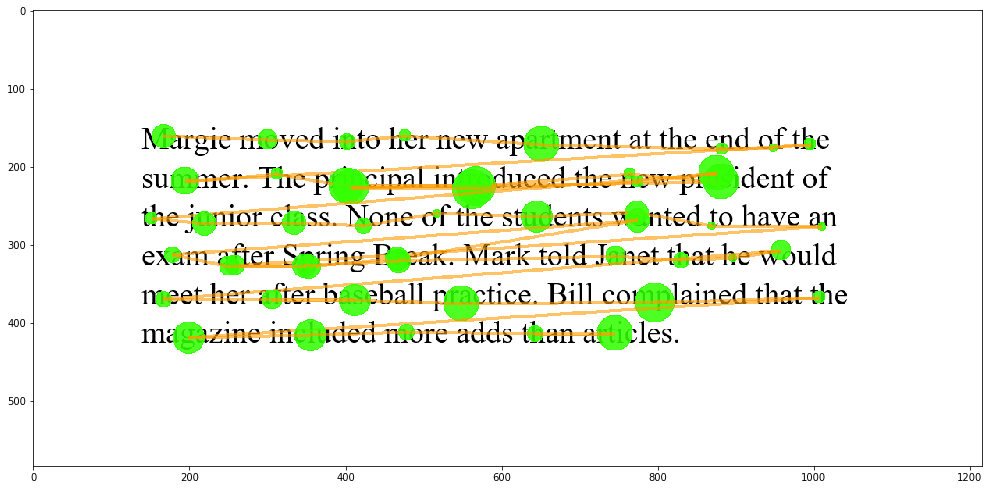

In [4]:
# draw original correct fixations

correction.draw_fixation('synthetic_text.png', data['robot1'].copy())

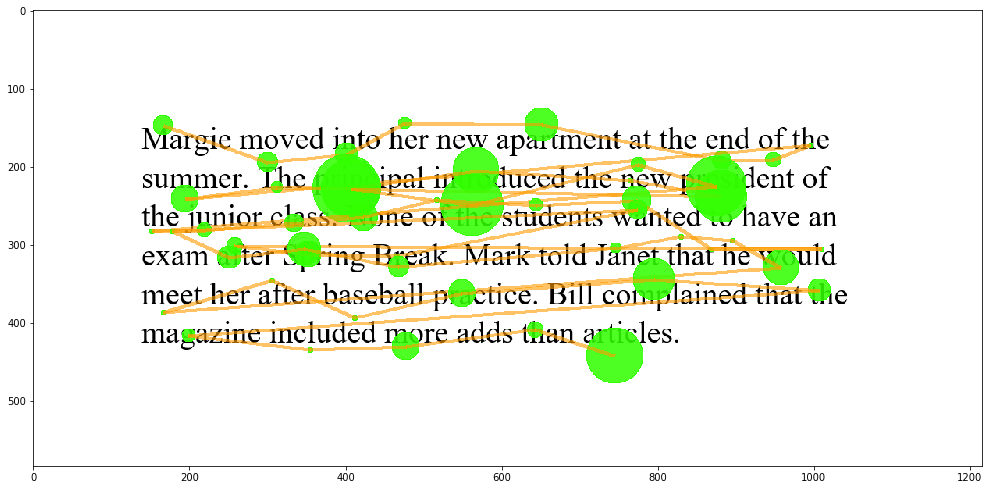

In [5]:
# generate noise over the correct trial

error_test = correction.error_noise(1, 30, 1, data['robot1'].copy())

# draw the trial with added error
correction.draw_fixation('synthetic_text.png', error_test)

0.98


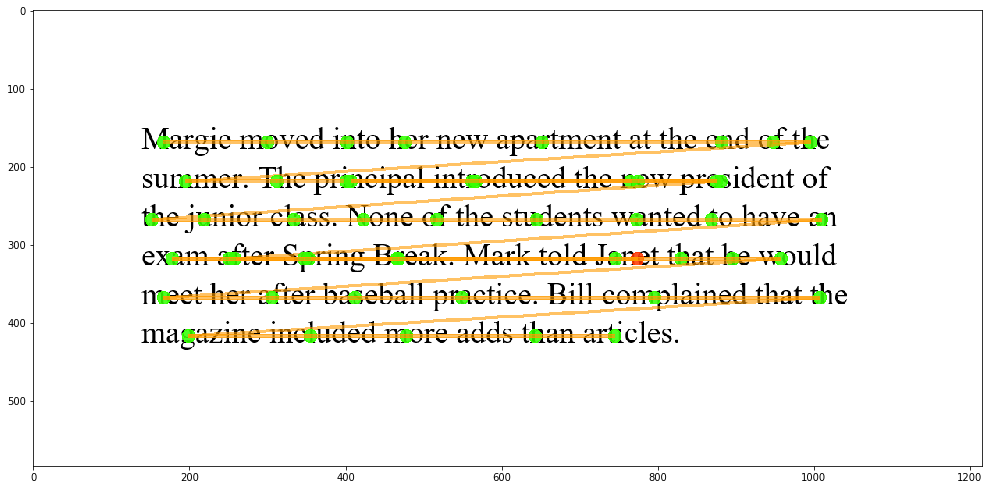

In [6]:
# find the center of each word, we need this for warp algorithm
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

# warp correction
np_array = np.array(error_test.copy(), dtype=int)
durations = np.delete(np_array, 0, 1)
durations = np.delete(durations, 0, 1)
np_array = np.delete(np_array, 2, 1)

# run warp
warp_correction = algo.warp(np_array, word_centers)

# this is a cool function that checks the quality of the correction
percentage, match_list = correction.correction_quality(aoi, data['robot1'].copy(), warp_correction)
print(percentage)

# this is a cool function that draws the correction in red if the algorithm made a mistake
correction.draw_correction('synthetic_text.png', warp_correction, match_list)

This concludes the example I wanted to show you of running an error generator, then correcting the data, then seeing how well the correction algorithm did.  You will need to repeat the same concept for a bunch of algorithms in the next section.

# Comparing algorithms with Noise error:

In this example, I show you one type of erro "Noise" you will implement all 5 types and add skipping to your assessment.  Also, the code below runs only 4 algorithms, you will add the remaining 6 algorithms to this assessment for each type of error. 

In [7]:
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

In [8]:
duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

In [9]:
import time

ct = lambda : int(time.time() * 1000)
class Timer():
    def __init__(self):
        self.past = 0
    
    def start(self):
        self.past = ct()
        
    def end(self):
        x = ct() - self.past
        return x

In [27]:
algorithms = ["attach", "chain", "cluster", "compare", "merge", "regress", "segment", "split", "stretch", "warp"]

def run_error_on_algorithms(error_function, data, num_runs = 1):
    '''
    
    error_function should be a callable with the signature (error_probability, data)
    - error_probability is range(0,11) (ie, 0 through 10)
    - data is the ground truth data for noise to be added on
    - robot_index is the string key
    '''
    

    
    results = {alg:[[],[],[],[],[],[],[],[],[],[],[]] for alg in algorithms}

    word_center_algo = ["compare", "warp"]

    for robot_index in tqdm(range(num_runs)):
        robot_str = 'robot' + str(robot_index)
        print("starting robot_index", robot_index)
        for error_probability in range(0, 11):

            error_test = error_function(error_probability, data, robot_str)

            for alg in algorithms:
                error_test_copy = np.array(error_test.copy())
                if alg in word_center_algo:
                    model_guess = getattr(algo, alg)(error_test_copy[:,:2], word_centers)
                else:
                    model_guess = getattr(algo, alg)(error_test_copy, np.array(line_ys))

                #print(aoi.shape, np.array(data["robot1"]).shape, model_guess.shape)
                percentage, match_list = correction.correction_quality(aoi, data[robot_str].copy(), model_guess)
                results[alg][error_probability].append(percentage)

            if percentage < 1:
                #correction.draw_correction('synthetic_text.png', warp_correction, match_list)
                print("robot:", robot_index, "    error probability:", error_probability)

    return results

import matplotlib.pyplot as plt


In [28]:
import statistics

def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

In [30]:
def plot_results(mean_results):
    
    
    
    markers = ".ov^<>1234"
    for i, alg in enumerate(algorithms):
        plt.plot(mean_results[alg], marker=markers[i]) # color='Black', linewidth=1, marker='^')

    plt.legend(algorithms)
    plt.ylabel('accuracy')
    plt.xlabel('noise')

    x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
    plt.xticks(range(0, 11), x_ticks_labels)
    #plt.savefig("noise_comparison.png")
    plt.show()

    


In [31]:
def noise_error(prob, data, robot_str):
    x = correction.error_noise(prob/10, 30, prob/10, data[robot_str].copy())
    return x

noise_results = run_error_on_algorithms(noise_error, data)


  0%|          | 0/1 [00:00<?, ?it/s]

starting robot_index 0
robot: 0     error probability: 0
robot: 0     error probability: 1
robot: 0     error probability: 2
robot: 0     error probability: 3
robot: 0     error probability: 4
robot: 0     error probability: 5
robot: 0     error probability: 6
robot: 0     error probability: 7
robot: 0     error probability: 8
robot: 0     error probability: 9


100%|██████████| 1/1 [00:48<00:00, 48.74s/it]

robot: 0     error probability: 10


In [32]:
noise_results

{'attach': [[1.0],
  [0.9857142857142858],
  [0.9714285714285714],
  [0.9571428571428572],
  [0.9571428571428572],
  [0.9285714285714286],
  [0.9],
  [0.9],
  [0.8428571428571429],
  [0.8285714285714286],
  [0.7857142857142857]],
 'chain': [[1.0],
  [1.0],
  [0.9857142857142858],
  [0.9857142857142858],
  [0.9857142857142858],
  [0.9714285714285714],
  [0.9714285714285714],
  [0.9428571428571428],
  [0.9285714285714286],
  [0.8714285714285714],
  [0.8857142857142857]],
 'cluster': [[1.0],
  [0.9857142857142858],
  [0.9714285714285714],
  [0.9428571428571428],
  [0.9571428571428572],
  [0.9285714285714286],
  [0.9],
  [0.8142857142857143],
  [0.7285714285714285],
  [0.8],
  [0.6857142857142857]],
 'compare': [[0.8285714285714286],
  [0.8285714285714286],
  [0.8285714285714286],
  [0.8285714285714286],
  [0.8285714285714286],
  [0.8285714285714286],
  [0.8285714285714286],
  [0.8285714285714286],
  [0.8285714285714286],
  [0.8285714285714286],
  [0.8285714285714286]],
 'merge': [[1.0],
 

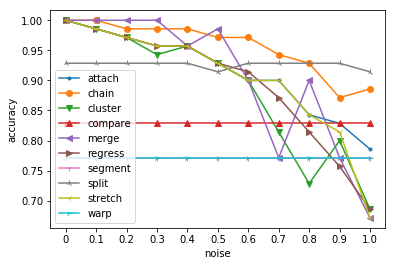

In [33]:
mean_noise_results = {alg:mean_error_group(noise_results[alg]) for alg in algorithms}
plot_results(mean_noise_results)

In [34]:
for alg in algorithms:
    print(f"mean {alg}:", statistics.mean(mean_results[alg]))

NameError: name 'mean_results' is not defined